# 重回帰分析



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbc                                                                                                       
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas_profiling import ProfileReport
import lmdiag

/usr/local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
%matplotlib inline

In [3]:
TRAIN_PATH = "/workspace/data/house_prices/train.csv"

train_df = pd.read_csv(TRAIN_PATH)
# columns=["Id", "OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea", "SalePrice"]
# train_df = train_df[columns]

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA後の対応

In [5]:
# 価格が下位1％の家と価格が高い中でも外れ値の家を削除
# 上下位1%ずつを抽出
train_df = train_df.sort_values("SalePrice")

low_row = round(train_df.shape[0] * 0.01)
low = train_df.iloc[:low_row].copy()
low_id_list = list(low['Id'].unique())

outlier_id_list = [524, 1299]

train_df = train_df.query(" (Id not in @low_id_list) & (Id not in @outlier_id_list)").copy()

In [6]:
columns_list = ["SalePrice"]

for x in columns_list:
    train_df[x] = train_df[x].apply(lambda x: np.log(x))

In [7]:
train_df["AllSF"] = train_df["GrLivArea"] + train_df["TotalBsmtSF"]
train_df["AllFlrsSF"] = train_df["1stFlrSF"] + train_df["2ndFlrSF"]

In [8]:
train_df = train_df.fillna(0)

# 重回帰

### AICにて最も良いモデルを検証

In [20]:
columns_list = [["GrLivArea"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageArea"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea", "YearBuilt"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea", "TotRmsAbvGrd"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "FullBath", "GarageArea", "YearBuilt", "TotRmsAbvGrd"],
                ["OverallQual", "GrLivArea", "TotalBsmtSF", "GarageArea", "YearBuilt"],
                ["OverallQual", "GarageArea", "YearBuilt", "AllSF", "YearRemodAdd"],
                ["OverallQual", "GarageArea", "YearBuilt", "AllFlrsSF", "YearRemodAdd"],
                ["OverallQual", "GarageArea", "YearBuilt", "AllSF", "AllFlrsSF", "YearRemodAdd"],
                ["OverallQual", "GarageArea", "YearBuilt", "AllSF", "AllFlrsSF", "YearRemodAdd", "OverallCond"],
                ["OverallQual", "GarageArea", "YearBuilt", "AllSF", "AllFlrsSF", "YearRemodAdd", "LotFrontage"]
                ]
for columns in columns_list:
    X =  train_df[columns].copy()
    y = train_df[["SalePrice"]].copy()
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size =0.8, random_state=0)
    
    # 標準化
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    
    mod = sm.OLS(y_train, sm.add_constant(x_train))
    result = mod.fit() 
    print(round(result.aic), columns)
    # result = mod.fit_regularized(method="elastic_net", alpha=0.01)
    # display(result.params)

173 ['GrLivArea']
-907 ['OverallQual', 'GrLivArea', 'TotalBsmtSF']
-1016 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']
-1023 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'GarageArea']
-1211 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'GarageArea', 'YearBuilt']
-1025 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'GarageArea', 'TotRmsAbvGrd']
-1210 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'GarageArea', 'YearBuilt', 'TotRmsAbvGrd']
-1207 ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']
-1227 ['OverallQual', 'GarageArea', 'YearBuilt', 'AllSF', 'YearRemodAdd']
-1065 ['OverallQual', 'GarageArea', 'YearBuilt', 'AllFlrsSF', 'YearRemodAdd']
-1262 ['OverallQual', 'GarageArea', 'YearBuilt', 'AllSF', 'AllFlrsSF', 'YearRemodAdd']
-1408 ['OverallQual', 'GarageArea', 'YearBuilt', 'AllSF', 'AllFlrsSF', 'YearRemodAdd', 'OverallCond']
-1262 ['OverallQual', 'GarageArea', 'YearBuilt', 'AllSF', 'AllFlrsSF', 'YearRemodAdd', 'L

### AIC最小モデルにて重回帰を実施

In [81]:
# 回帰モデル作成
columns=["OverallQual", "GarageArea", "YearBuilt", "AllSF", "AllFlrsSF", "YearRemodAdd", "OverallCond"]
X =  train_df[columns].copy()
y = train_df[["SalePrice"]].copy()

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size =0.8, random_state=0)

# 標準化
scaler = StandardScaler()
scaler.fit(x_train[columns])
x_train = scaler.transform(x_train[columns])
x_test = scaler.transform(x_test[columns])

mod = sm.OLS(y_train, sm.add_constant(x_train))

# 訓練
result = mod.fit() 

# 統計サマリを表示
print(result.summary())
# print(result.aic)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1198.
Date:                Thu, 03 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:38:48   Log-Likelihood:                 711.88
No. Observations:                1154   AIC:                            -1408.
Df Residuals:                    1146   BIC:                            -1367.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0432      0.004   3122.321      0.0

### 説明変数同士の相関係数

### 回帰診断

等分散でなく、正規性もない。
果てには外れ値判定もめちゃくちゃされている・・・・。

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

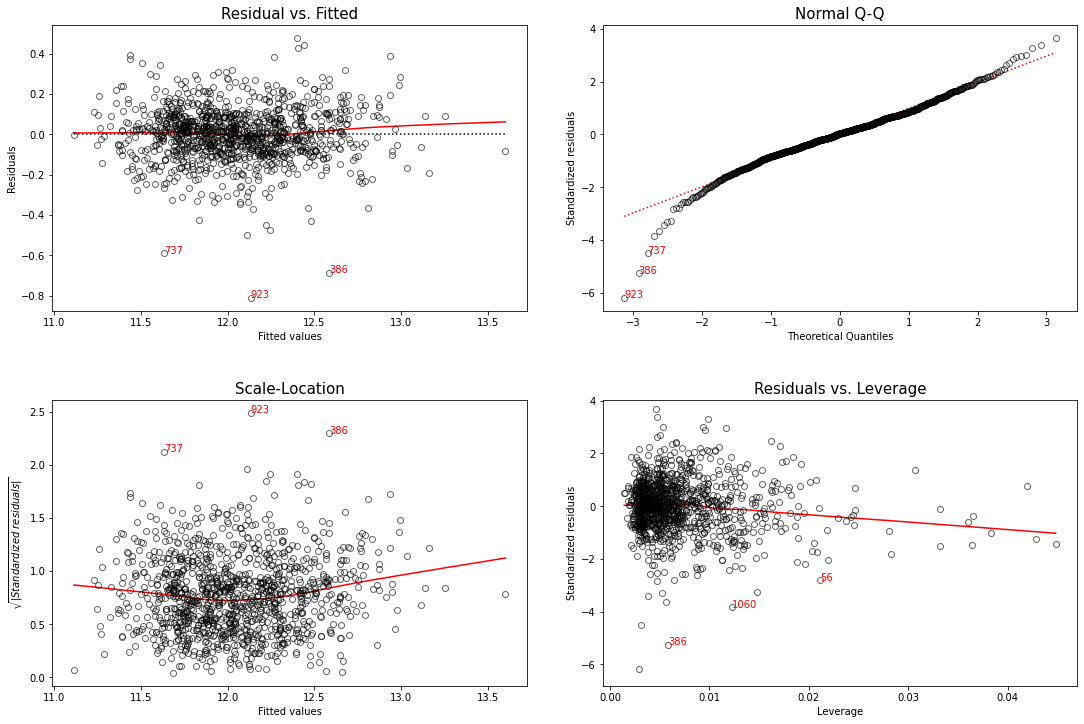

In [82]:
plt.figure(figsize=(15,10))
lmdiag.plot(result)

## 過学習の確認

### RMSE

In [83]:
# モデル使用データ
x_test_result = pd.DataFrame({"SalePrice":result.predict(sm.add_constant(x_train))})
x_test_result['predict'] = x_test_result['SalePrice'].apply(lambda x :np.exp(x))
y_train['answer'] = y_train['SalePrice'].apply(lambda x :np.exp(x))

check_df = pd.concat([pd.DataFrame(x_train, columns=columns), y_train.drop("SalePrice", axis=1)], axis=1)
check_df = pd.concat([check_df, x_test_result.drop("SalePrice", axis=1)], axis=1)

rmse = eval_measures.rmse(y_train['answer'], x_test_result['predict'])
print("モデル使用データ　RMSE", round(rmse))

# ==========================================================-

# テストデータ
x_test_result = pd.DataFrame({"SalePrice":result.predict(sm.add_constant(x_test))})
x_test_result['predict'] = x_test_result['SalePrice'].apply(lambda x :np.exp(x))

y_test['answer'] = y_test['SalePrice'].apply(lambda x :np.exp(x))

check_df = pd.concat([pd.DataFrame(x_test, columns=columns), y_test.drop("SalePrice", axis=1)], axis=1)
check_df = pd.concat([check_df, x_test_result.drop("SalePrice", axis=1)], axis=1)

rmse = eval_measures.rmse(y_test['answer'], x_test_result['predict'])
print("テストデータ　RMSE", round(rmse))

モデル使用データ　RMSE 26875
テストデータ　RMSE 26330


### モデルを作成したデータで正解データと予測データで比較

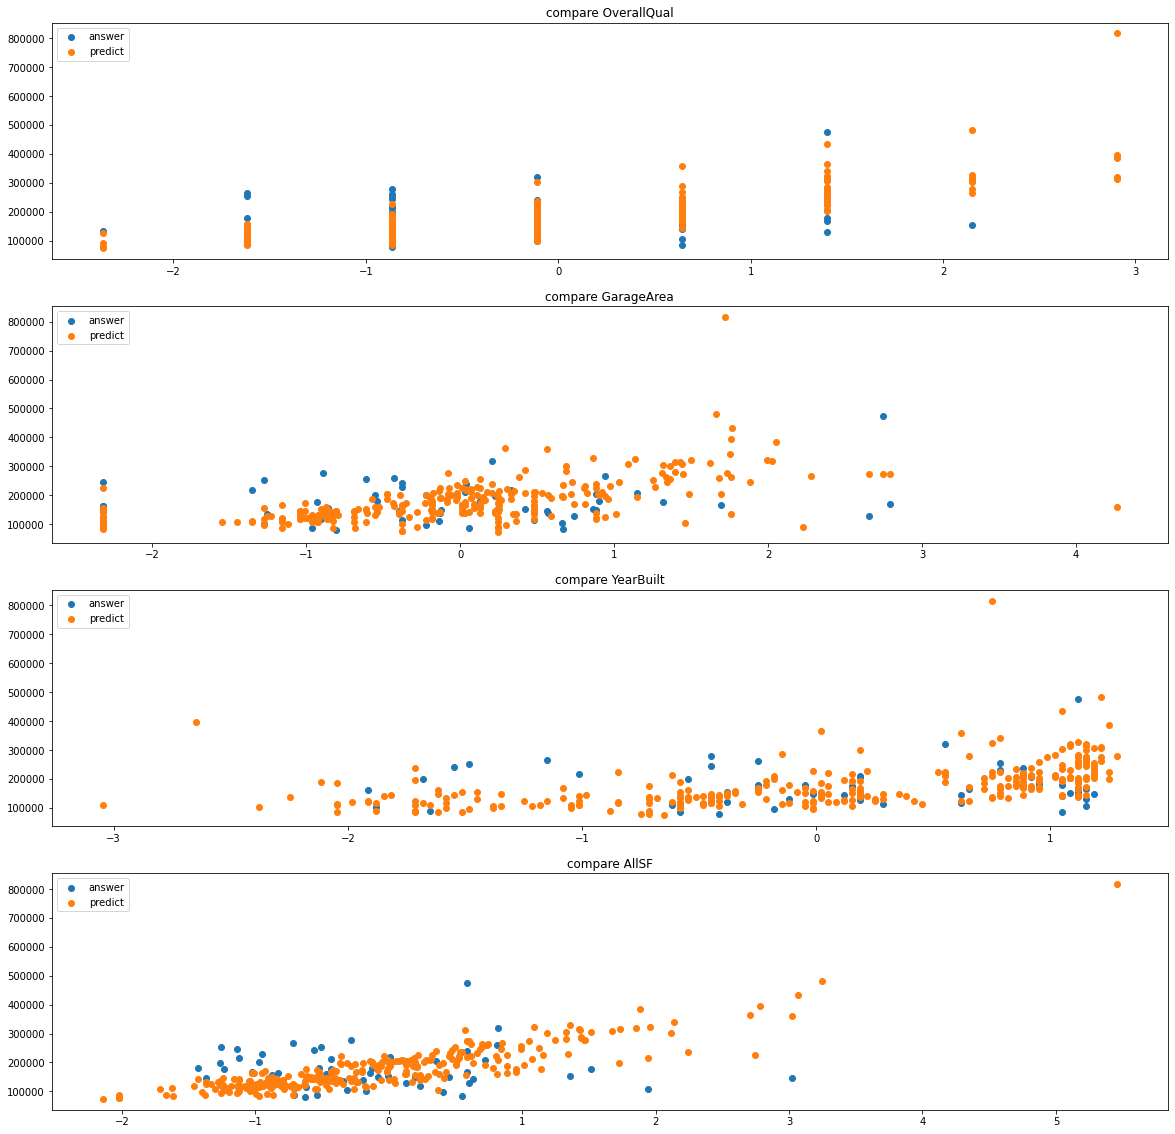

In [84]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots(4,1)

for i, column in enumerate(["OverallQual", "GarageArea", "YearBuilt", "AllSF"]):

    ax[i].scatter(check_df[column], check_df['answer'], label='answer')
    ax[i].scatter(check_df[column], check_df['predict'], label='predict')
    ax[i].set_title(f"compare {column}")
    ax[i].legend(loc="upper left")

### テストデータで正解データと予測データで比較

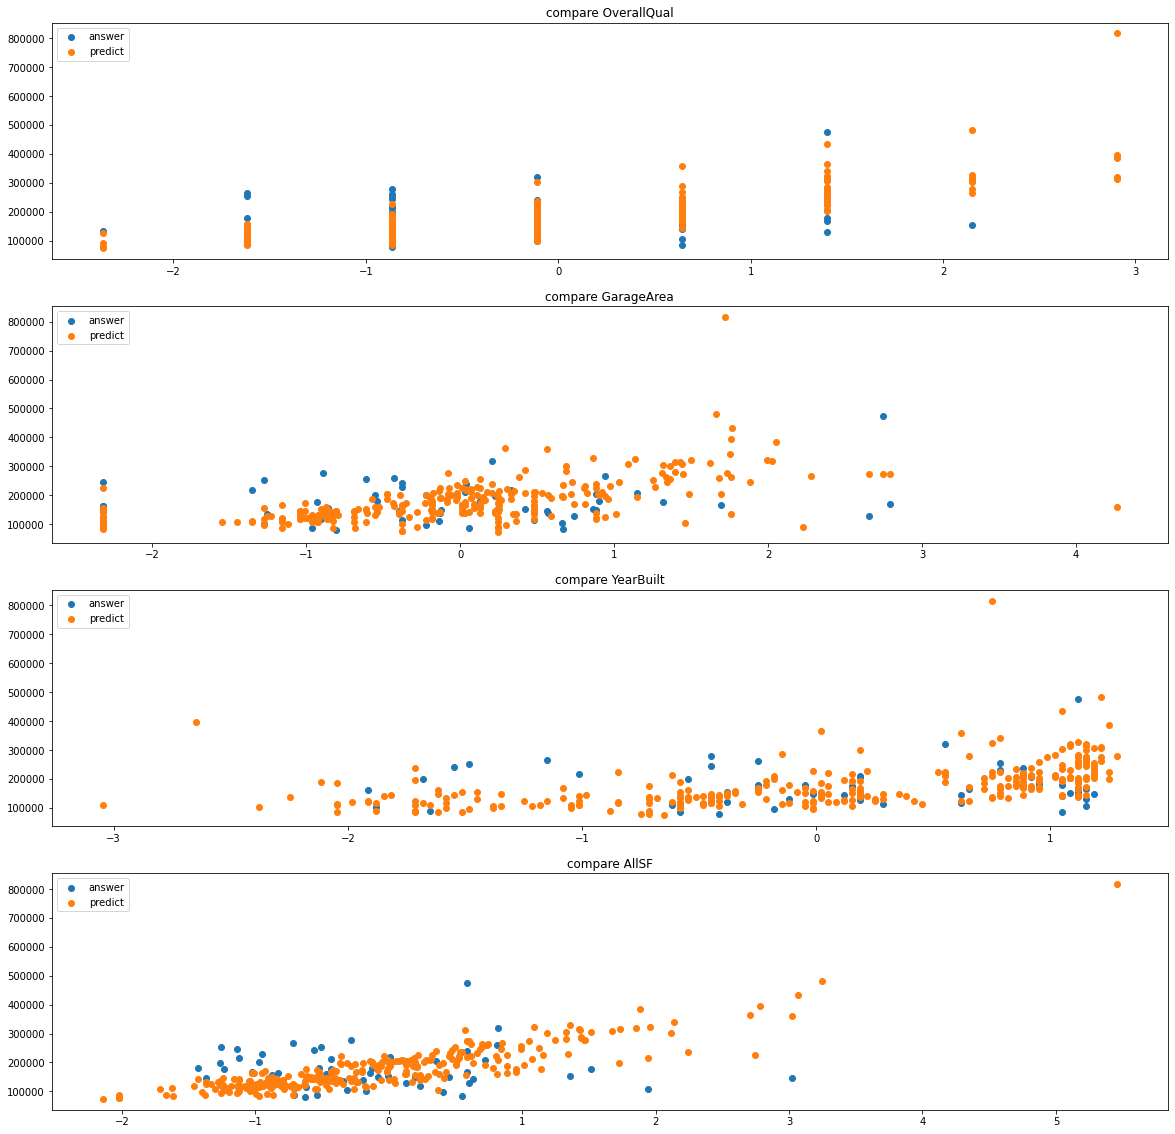

In [85]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots(4,1)

for i, column in enumerate(["OverallQual", "GarageArea", "YearBuilt", "AllSF"]):

    ax[i].scatter(check_df[column], check_df['answer'], label='answer')
    ax[i].scatter(check_df[column], check_df['predict'], label='predict')
    ax[i].set_title(f"compare {column}")
    ax[i].legend(loc="upper left")


# 予測

In [86]:
TEST_PATH = "/workspace/data/house_prices/test.csv"
test_df = pd.read_csv(TEST_PATH)
test_df = test_df.fillna(0)

test_df["AllSF"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]
test_df["AllFlrsSF"] = test_df["1stFlrSF"] + test_df["2ndFlrSF"]
x_test = test_df[columns]

In [106]:
test_result = pd.DataFrame({"SalePrice":result.predict(sm.add_constant(x_test))})
test_result['SalePrice'] = test_result['SalePrice'].apply(lambda x :np.exp(x))
test_result = pd.concat([test_df, test_result],axis=1)

In [108]:
test_result[["Id", "SalePrice"]].to_csv("/workspace/data/house_prices/result.csv", index=False, encoding='utf-8-sig')